In [3]:
import numpy as np

In [1]:
import pandas as pd

monthly = pd.read_csv("../data/final_dataset/processed/monthly_features.csv")

monthly["year_month"] = pd.to_datetime(monthly["year_month"].astype(str)).dt.to_period("M")


In [13]:
monthly.describe()

,total_amount,transaction_count,avg_transaction,target_next_month,amount_lag_1,count_lag_1,amount_lag_3,count_lag_3,amount_lag_6,count_lag_6,amount_roll_3m,amount_roll_6m
count,2.355400e+05,235540.000000,2.355400e+05,2.355400e+05,2.355400e+05,235540.000000,2.355400e+05,235540.000000,2.355400e+05,235540.000000,2.355400e+05,2.355400e+05
mean,1.669916e+07,22.484665,5.567223e+05,1.647260e+07,1.699182e+07,22.544298,1.638118e+07,22.534402,1.556199e+07,22.169547,1.675542e+07,1.650976e+07
std,6.285024e+08,66.569262,2.310701e+07,5.796535e+08,6.439637e+08,66.978338,6.204082e+08,69.045666,5.914588e+08,71.933064,5.279580e+08,4.532117e+08
min,2.654193e-03,1.000000,2.654193e-03,4.068308e-03,2.654193e-03,1.000000,2.654193e-03,1.000000,4.521599e-04,1.000000,2.680984e-02,3.617630e-02
25%,2.100127e+05,5.000000,2.913950e+04,2.083384e+05,2.120046e+05,5.000000,2.121902e+05,5.000000,1.996249e+05,5.000000,3.154104e+05,3.741705e+05
50%,1.106096e+06,13.000000,7.964296e+04,1.111894e+06,1.105932e+06,13.000000,1.094199e+06,13.000000,1.032660e+06,13.000000,1.346635e+06,1.464783e+06
75%,4.422907e+06,29.000000,2.083619e+05,4.479902e+06,4.400377e+06,29.000000,4.308146e+06,29.000000,4.085754e+06,28.000000,4.893037e+06,5.064336e+06
max,1.187547e+11,7246.000000,7.404870e+09,1.187547e+11,1.187547e+11,7246.000000,1.187547e+11,7730.000000,1.187547e+11,8301.000000,8.368617e+10,6.723875e+10


In [4]:
split_month = monthly["year_month"].quantile(0.8)

train = monthly[monthly["year_month"] <= split_month]
valid = monthly[monthly["year_month"] > split_month]

features = [
    "total_amount",
    "transaction_count",
    "avg_transaction",
    "amount_lag_1",
    "amount_lag_3",
    "amount_lag_6",
    "count_lag_1",
    "count_lag_3",
    "amount_roll_3m",
    "amount_roll_6m",
]

X_train = train[features]
X_valid = valid[features]

y_train = np.log1p(train["target_next_month"])
y_valid = np.log1p(valid["target_next_month"])

Используем регрессионную модель

In [ ]:
!pip install -r "../requirements.txt"

In [9]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)

pred_log = model.predict(X_valid)
pred = np.expm1(pred_log)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 193052, number of used features: 10
[LightGBM] [Info] Start training from score 13.605762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [10]:
mae = mean_absolute_error(valid["target_next_month"], pred)
r2 = r2_score(valid["target_next_month"], pred)

relative_error = np.abs(pred - valid["target_next_month"]) / valid["target_next_month"]
accuracy_15 = (relative_error <= 0.15).mean()

mae, r2, accuracy_15

(14872880.627598476, 0.030579086859014892, np.float64(0.13745057427979665))

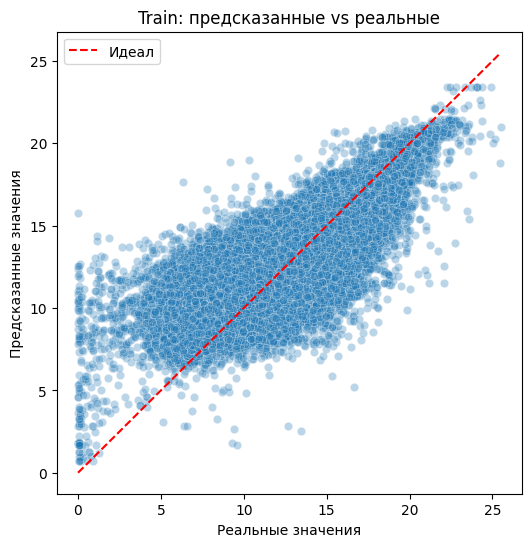

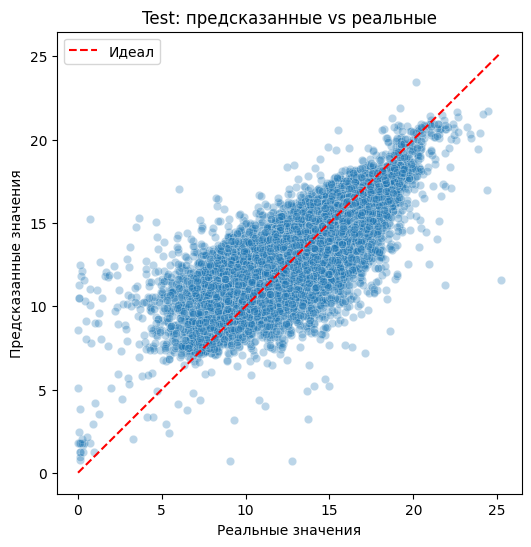

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# model — обученная модель LightGBM
# X_train
# X_valid

# y_train
# y_valid

# Получаем предсказания
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_valid)

# Если логарифм применялся при обучении
# y_pred_train = np.expm1(y_pred_train)
# y_pred_test = np.expm1(y_pred_test)
# y_train = np.expm1(y_train)
# y_valid = np.expm1(y_valid)

# Функция для графика
def plot_pred_vs_true(y_valid, y_pred, title):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_valid, y=y_pred, alpha=0.3)
    plt.plot([y_valid.min(), y_valid.max()],
             [y_valid.min(), y_valid.max()],
             color='red', linestyle='--', label='Идеал')
    plt.xlabel("Реальные значения")
    plt.ylabel("Предсказанные значения")
    plt.title(title)
    plt.legend()
    plt.show()


plot_pred_vs_true(y_train, y_pred_train, "Train: предсказанные vs реальные")

plot_pred_vs_true(y_valid, y_pred_test, "Test: предсказанные vs реальные")
